<img src='../images/copernicus_eumetsat_logo.jpg' alt='Copernicus EUMETSAT' align='right' width='50%'></img>

# Ozone retrieval
For this exercise we will download a dataset of $O_3$ concentration from the TROPOMI instrument on board the Copernicus Sentinel-5p satellite. The dataset can be donloaded from the [Copernicus Dataspace](https://dataspace.copernicus.eu/). In order to download the dataset we have to select an areao of interest, the dates, and the product. From the menu we select: Sentinel-5p -> TROPOMI -> Level-2 O3. The tool can show us the available products. After the download we can use [Panoply](https://www.giss.nasa.gov/tools/panoply/) to have a look at the structure of the dataset.  

In [3]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import requests
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
import matplotlib.colors as mcol
from matplotlib.colors import ListedColormap
from zipfile import ZipFile
import netCDF4 as nc4
from zipfile import ZipFile

In [4]:
data_url = 'https://sites.ecmwf.int/training/cams-act6/AK/AK2-data.zip'
r = requests.get(data_url)
DATADIR = '.'
file_path = f'download.zip'
with open(file_path, 'wb') as f:
        f.write(r.content)

In [5]:
with ZipFile(f'{DATADIR}/download.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall(path=f'{DATADIR}')

In [6]:
os.remove(f'{DATADIR}/download.zip')

The L2_O3 dataset is structured into two groups at the root level: PRODUCT and METADATA. The ozone total vertical column is in the PRODUCT group. The PRODUCT group contains a sub groups SUPPORT_DATA that itself contains three more sub groups: DETAILED_RESULTS, GEOLOCATIONS, and INPUT_DATA. The averaging kernel is in DETAILED_RESULTS

In [21]:
#file_path = './AK2-data/O3/S5P_NRTI_L2__O3__PR_20240314T110748_20240314T111248_33256_03_020600_20240314T115305.nc'
file_path = './AK2-data/O3/CAMS_O3_forecast_20240314_12utc.nc'

In [22]:
from netCDF4 import Dataset
fh = Dataset(file_path, mode='r')
fh.groups

{}

In [23]:
bb_north = 50.4687
bb_south = 42.0917
bb_west = -5.4580
bb_east = 7.4794
area_of_interest = [bb_north, bb_west, bb_south, bb_east]

## Ozone total vertical column

In [26]:
o3_ds = xr.open_dataset(file_path)
o3_ds

<xarray.Dataset> Size: 224MB
Dimensions:                   (time: 1, level: 137, lat: 451, lon: 900,
                               model_level_coefficients: 138)
Coordinates:
  * level                     (level) float64 1kB 1.0 2.0 3.0 ... 136.0 137.0
  * model_level_coefficients  (model_level_coefficients) int64 1kB 0 1 ... 137
  * lon                       (lon) float64 7kB 0.0 0.4 0.8 ... 359.2 359.6
  * lat                       (lat) float64 4kB 90.0 89.6 89.2 ... -89.6 -90.0
Dimensions without coordinates: time
Data variables:
    o3                        (time, level, lat, lon) float32 222MB ...
    sp                        (time, lat, lon) float32 2MB ...
    a                         (model_level_coefficients) float32 552B ...
    b                         (model_level_coefficients) float32 552B ...

In [29]:
latitude = o3_ds['lat']

In [31]:
longitude = o3_ds['lon']

The variable *ozone_total_vertical_column* does not have latitude and longitude

In [32]:
o3_da = o3_ds['o3']
o3_da

<xarray.DataArray 'o3' (time: 1, level: 137, lat: 451, lon: 900)> Size: 222MB
[55608300 values with dtype=float32]
Coordinates:
  * level    (level) float64 1kB 1.0 2.0 3.0 4.0 5.0 ... 134.0 135.0 136.0 137.0
  * lon      (lon) float64 7kB 0.0 0.4 0.8 1.2 1.6 ... 358.4 358.8 359.2 359.6
  * lat      (lat) float64 4kB 90.0 89.6 89.2 88.8 ... -88.8 -89.2 -89.6 -90.0
Dimensions without coordinates: time

In [36]:
o3_lev46_da = o3_da.sel(level=46)
o3_lev46_da

<xarray.DataArray 'o3' (time: 1, lat: 451, lon: 900)> Size: 2MB
array([[[7.574726e-06, 7.574726e-06, ..., 7.574726e-06, 7.574726e-06],
        [7.569809e-06, 7.569741e-06, ..., 7.569974e-06, 7.569892e-06],
        ...,
        [5.043419e-06, 5.043201e-06, ..., 5.043834e-06, 5.043626e-06],
        [5.037442e-06, 5.037442e-06, ..., 5.037442e-06, 5.037442e-06]]],
      dtype=float32)
Coordinates:
    level    float64 8B 46.0
  * lon      (lon) float64 7kB 0.0 0.4 0.8 1.2 1.6 ... 358.4 358.8 359.2 359.6
  * lat      (lat) float64 4kB 90.0 89.6 89.2 88.8 ... -88.8 -89.2 -89.6 -90.0
Dimensions without coordinates: time

In [33]:
def create_figure(): 
    fig = plt.figure(figsize=(20,10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.OCEAN)
    ax.add_feature(cartopy.feature.LAND, edgecolor='black')
    ax.coastlines()
    ax.set_extent([bb_west, bb_east, bb_south, bb_north], ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True, linestyle='--')
    return fig, ax

Text(0.5, 1.0, 'O3 total vertical column - 2024-08-18')

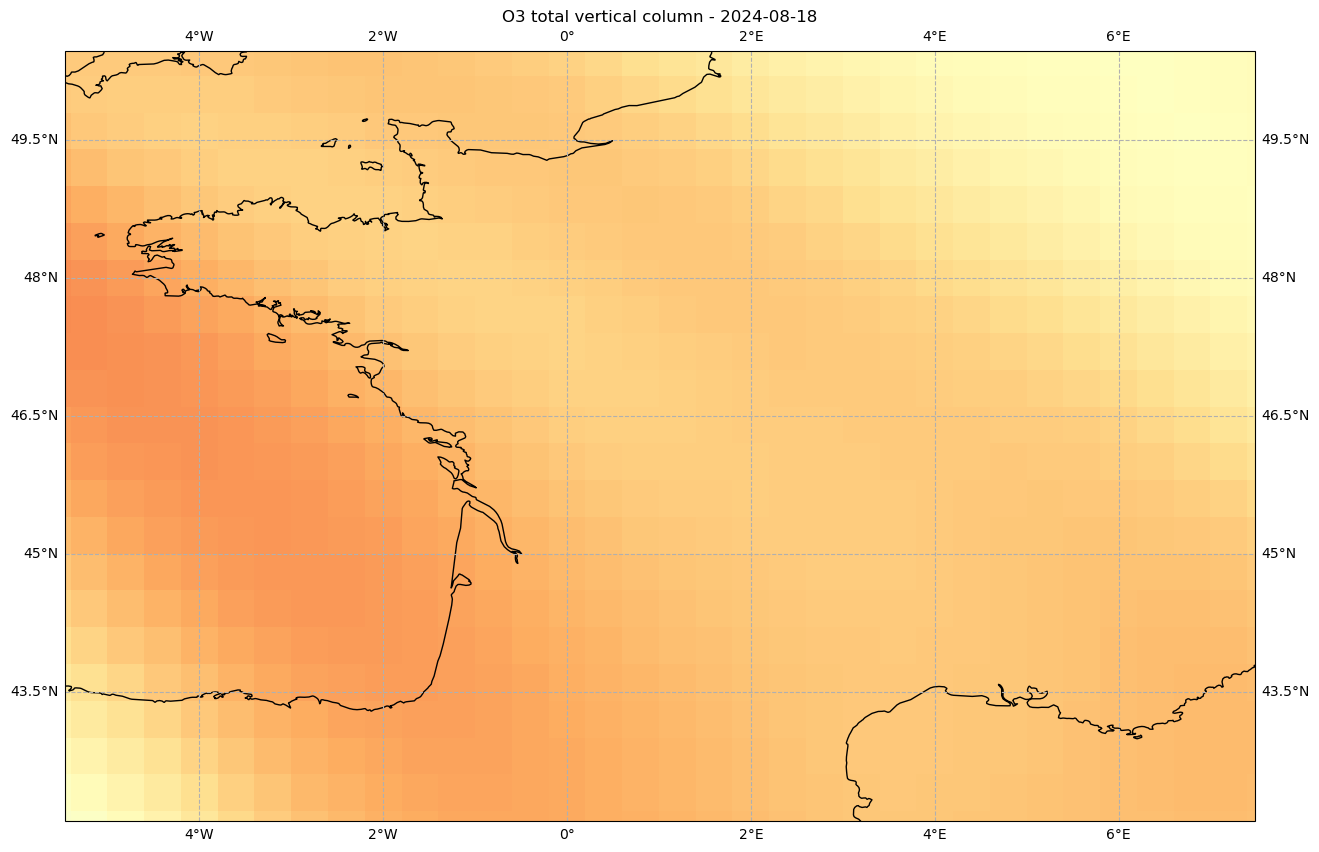

In [38]:
_, ax = create_figure()
plt.pcolormesh(longitude, 
               latitude, 
               o3_lev46_da[0],
               cmap='RdYlBu_r',
               shading='auto',
               transform=ccrs.PlateCarree())
plt.title('O3 total vertical column - 2024-08-18')

## Averaging kernel

In [37]:
o3_support_ds = xr.open_dataset(path + filename, group='PRODUCT/SUPPORT_DATA/DETAILED_RESULTS')
o3_support_ds

<xarray.Dataset>
Dimensions:                                 (time: 1, scanline: 357,
                                             ground_pixel: 450, layer: 13,
                                             level: 14,
                                             number_of_slant_columns: 4,
                                             number_of_doas_polynomial_coefficients: 4)
Coordinates:
  * number_of_slant_columns                 (number_of_slant_columns) int32 0...
  * number_of_doas_polynomial_coefficients  (number_of_doas_polynomial_coefficients) int32 ...
Dimensions without coordinates: time, scanline, ground_pixel, layer, level
Data variables: (12/25)
    ozone_profile_apriori                   (time, scanline, ground_pixel, layer) float32 ...
    averaging_kernel                        (time, scanline, ground_pixel, layer) float32 ...
    pressure_grid                           (time, scanline, ground_pixel, level) float32 ...
    fitted_slant_columns                    (time, scanline, ground_pixel, number_of_slant_columns) float64 ...
    fitted_slant_columns_precision          (time, scanline, ground_pixel, number_of_slant_columns) float32 ...
    number_of_iterations_slant_column       (time, scanline, ground_pixel) float32 ...
    ...                                      ...
    number_of_iterations_vertical_column    (time, scanline, ground_pixel) float32 ...
    effective_scene_albedo                  (time, scanline, ground_pixel) float32 ...
    effective_scene_albedo_precision        (time, scanline, ground_pixel) float32 ...
    doas_polynomial_coefficients            (time, scanline, ground_pixel, number_of_doas_polynomial_coefficients) float32 ...
    euv                                     (time, scanline, ground_pixel) float32 ...
    processing_quality_flags                (time, scanline, ground_pixel) float64 ...

In [117]:
o3_averaging_kernel = o3_support_ds['averaging_kernel']
o3_averaging_kernel.shape
o3_averaging_kernel

<xarray.DataArray 'averaging_kernel' (time: 1, scanline: 357,
                                      ground_pixel: 450, layer: 13)>
array([[[[     nan, ...,      nan],
         ...,
         [0.273834, ..., 1.063437]],

        ...,

        [[     nan, ...,      nan],
         ...,
         [0.259664, ..., 1.060363]]]], dtype=float32)
Dimensions without coordinates: time, scanline, ground_pixel, layer
Attributes:
    units:      1
    long_name:  ozone averaging kernel
    positive:   up

Text(0.5, 1.0, '$O_3$ Averagingg kernel layer 0- 2024-08-18')

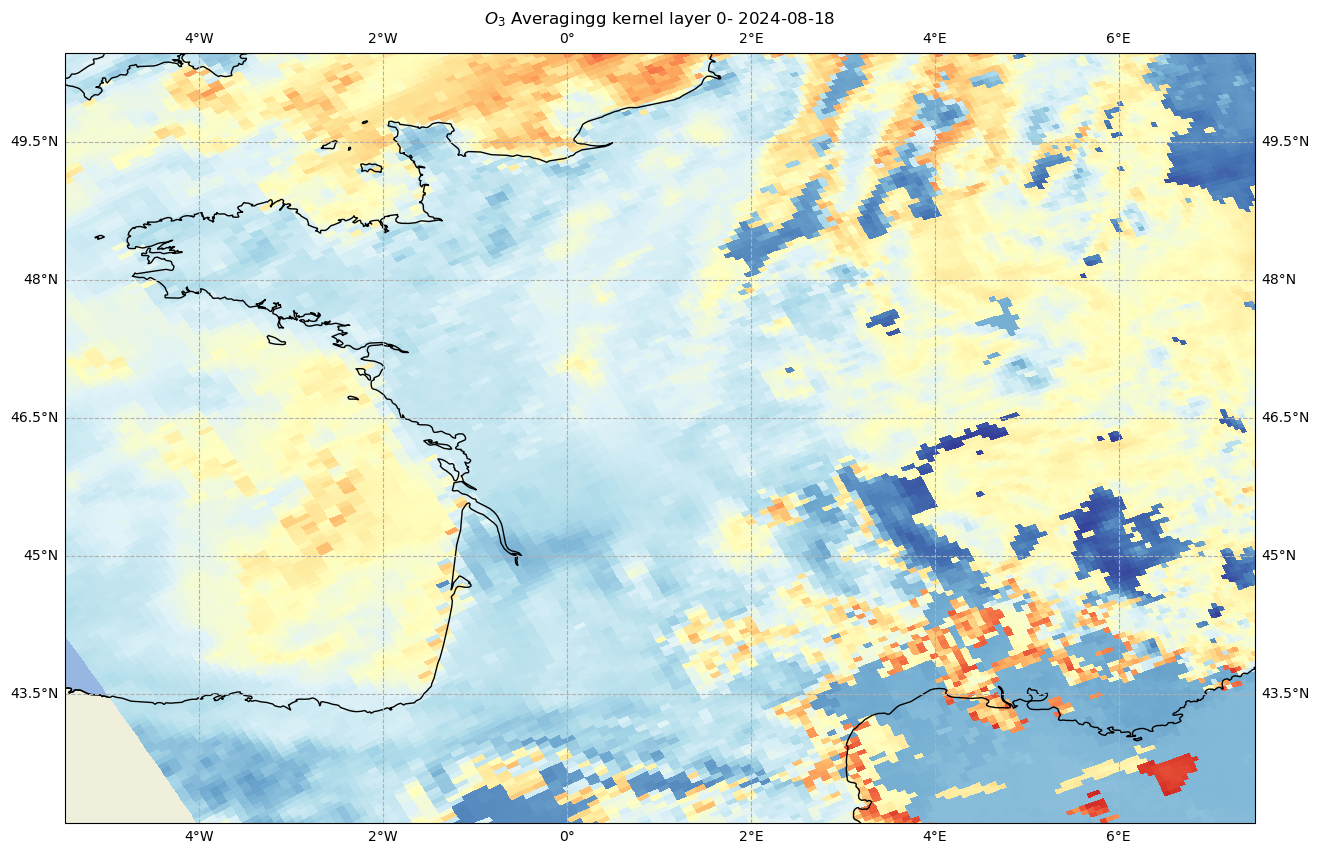

In [120]:
layer = 0
time = 0
_, ax = create_figure()
plt.pcolormesh(longitude, 
               latitude, 
               o3_averaging_kernel[time,:,:,layer],
               cmap='RdYlBu_r',
               shading='auto',
               transform=ccrs.PlateCarree())
plt.title('$O_3$ Averaging kernel layer {:d} - 2024-08-18'.format(layer))

## CAMS 3D Ozone Field
We download the ozone data for the selected area and dates from the [Copernicus Atmosphere Monitoring Service](https://ads-beta.atmosphere.copernicus.eu/datasets/cams-global-atmospheric-composition-forecasts?tab=overview). We retrieve all the pressure levels above the same area covered in the Sentinel-5p data and the same time window. 

In [24]:
DATADIR = 'data/CAMS'
start_date = '2024-08-18'
end_date = '2024-08-18'
WDIR = f'cams_3d_global_{start_date}_{end_date}'

In [25]:
import cdsapi

dataset = "cams-global-atmospheric-composition-forecasts"
request = {
    'variable': ['ozone'],
    'pressure_level': ['1', '2', '3', '5', '7', '10', '20', '30', '50', '70', '100', '150', '200', '250', '300', '400', '500', '600', '700', '800', '850', '900', '925', '950', '1000'],
    'date': [f'{start_date}/{end_date}'],
    'time': ['00:00'],
    'leadtime_hour': ['0', '3', '6', '9', '12', '15', '18', '21', '24'],
    'type': ['forecast'],
    'data_format': 'netcdf_zip',
    'area': [50.4687, -5.458, 42.0917, 7.4794]
}

In [26]:
client = cdsapi.Client()
client.retrieve(dataset, request).download()

2024-08-20 10:22:38,652 INFO Welcome to the CDS
2024-08-20 10:22:38,655 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-global-atmospheric-composition-forecasts
2024-08-20 10:22:38,700 INFO Request is queued
2024-08-20 10:22:39,732 INFO Request is running
2024-08-20 10:22:46,937 INFO Request is completed
2024-08-20 10:22:46,938 INFO Downloading https://download-0003-ads-clone.copernicus-climate.eu/cache-compute-0003/cache/data0/adaptor.mars_constrained.internal-1724142164.775677-22359-1-c8f76f54-3e99-473d-8690-b9b3481c823d.grib to adaptor.mars_constrained.internal-1724142164.775677-22359-1-c8f76f54-3e99-473d-8690-b9b3481c823d.grib (480.3K)
2024-08-20 10:22:49,069 INFO Download rate 225.3K/s


'adaptor.mars_constrained.internal-1724142164.775677-22359-1-c8f76f54-3e99-473d-8690-b9b3481c823d.grib'

In [27]:
with ZipFile(f'{DATADIR}/{WDIR}.zip', 'r') as zipObj:
   zipObj.extractall(path=f'{DATADIR}/{WDIR}/')

In [28]:
cams_o3_ds = xr.open_dataset(f'{DATADIR}/{WDIR}/data_plev.nc') 
cams_o3_ds

<xarray.Dataset>
Dimensions:                  (forecast_period: 9, forecast_reference_time: 1,
                              pressure_level: 25, latitude: 21, longitude: 33)
Coordinates:
  * forecast_period          (forecast_period) timedelta64[ns] 00:00:00 ... 1...
  * forecast_reference_time  (forecast_reference_time) datetime64[ns] 2024-08-18
  * pressure_level           (pressure_level) float64 1e+03 950.0 ... 2.0 1.0
  * latitude                 (latitude) float64 50.09 49.69 ... 42.49 42.09
  * longitude                (longitude) float64 -5.458 -5.058 ... 6.942 7.342
    valid_time               (forecast_reference_time, forecast_period) datetime64[ns] ...
Data variables:
    go3                      (forecast_period, forecast_reference_time, pressure_level, latitude, longitude) float32 ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-08-20T08:35 GRIB to CDM+CF via cfgrib-0.9.1...

In [31]:
cams_o3 = cams_o3_ds['go3'].sel(forecast_reference_time='2024-08-18')
cams_o3

<xarray.DataArray 'go3' (forecast_period: 9, pressure_level: 25, latitude: 21,
                         longitude: 33)>
[155925 values with dtype=float32]
Coordinates:
  * forecast_period          (forecast_period) timedelta64[ns] 00:00:00 ... 1...
    forecast_reference_time  datetime64[ns] 2024-08-18
  * pressure_level           (pressure_level) float64 1e+03 950.0 ... 2.0 1.0
  * latitude                 (latitude) float64 50.09 49.69 ... 42.49 42.09
  * longitude                (longitude) float64 -5.458 -5.058 ... 6.942 7.342
    valid_time               (forecast_period) datetime64[ns] ...
Attributes: (12/32)
    GRIB_paramId:                             210203
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      693
    GRIB_typeOfLevel:                         isobaricInhPa
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               kg kg**-1
    long_name:                                Ozone mass mixing ratio (full c...
    units:                                    kg kg**-1
    standard_name:                            mass_fraction_of_ozone_in_air
    GRIB_number:                              0

In [48]:
cams_o3.forecast_period

<xarray.DataArray 'forecast_period' (forecast_period: 9)>
array([             0, 10800000000000, 21600000000000, 32400000000000,
       43200000000000, 54000000000000, 64800000000000, 75600000000000,
       86400000000000], dtype='timedelta64[ns]')
Coordinates:
  * forecast_period          (forecast_period) timedelta64[ns] 00:00:00 ... 1...
    forecast_reference_time  datetime64[ns] 2024-08-18
    valid_time               (forecast_period) datetime64[ns] ...
Attributes:
    long_name:      time since forecast_reference_time
    standard_name:  forecast_period

In [57]:
delta_time = 3 * 60 * 60 * 10**9 # delta between one lead time and the next one
num_forecasts = 25
start_day = pd.to_datetime(start_date)
date_index = start_day + pd.to_timedelta(np.arange(num_forecasts, step=3), 'h')
date_index.size
start_day.strftime('%Y-%m-%d %H:%M:%S')

'2024-08-18 00:00:00'

In [75]:
date_index

DatetimeIndex(['2024-08-18 00:00:00', '2024-08-18 03:00:00',
               '2024-08-18 06:00:00', '2024-08-18 09:00:00',
               '2024-08-18 12:00:00', '2024-08-18 15:00:00',
               '2024-08-18 18:00:00', '2024-08-18 21:00:00',
               '2024-08-19 00:00:00'],
              dtype='datetime64[ns]', freq=None)

In [65]:
cams_o3_assigned = cams_o3.assign_coords(forecast_period=date_index)
cams_o3_assigned

<xarray.DataArray 'go3' (forecast_period: 9, pressure_level: 25, latitude: 21,
                         longitude: 33)>
[155925 values with dtype=float32]
Coordinates:
    forecast_reference_time  datetime64[ns] 2024-08-18
  * pressure_level           (pressure_level) float64 1e+03 950.0 ... 2.0 1.0
  * latitude                 (latitude) float64 50.09 49.69 ... 42.49 42.09
  * longitude                (longitude) float64 -5.458 -5.058 ... 6.942 7.342
    valid_time               (forecast_period) datetime64[ns] ...
  * forecast_period          (forecast_period) datetime64[ns] 2024-08-18 ... ...
Attributes: (12/32)
    GRIB_paramId:                             210203
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      693
    GRIB_typeOfLevel:                         isobaricInhPa
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               kg kg**-1
    long_name:                                Ozone mass mixing ratio (full c...
    units:                                    kg kg**-1
    standard_name:                            mass_fraction_of_ozone_in_air
    GRIB_number:                              0

In [66]:
cams_o3_assigned.sel(forecast_period='2024-08-18 03:00:00')

<xarray.DataArray 'go3' (pressure_level: 25, latitude: 21, longitude: 33)>
[17325 values with dtype=float32]
Coordinates:
    forecast_reference_time  datetime64[ns] 2024-08-18
  * pressure_level           (pressure_level) float64 1e+03 950.0 ... 2.0 1.0
  * latitude                 (latitude) float64 50.09 49.69 ... 42.49 42.09
  * longitude                (longitude) float64 -5.458 -5.058 ... 6.942 7.342
    valid_time               datetime64[ns] ...
    forecast_period          datetime64[ns] 2024-08-18T03:00:00
Attributes: (12/32)
    GRIB_paramId:                             210203
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      693
    GRIB_typeOfLevel:                         isobaricInhPa
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               kg kg**-1
    long_name:                                Ozone mass mixing ratio (full c...
    units:                                    kg kg**-1
    standard_name:                            mass_fraction_of_ozone_in_air
    GRIB_number:                              0

Text(0.5, 1.0, 'CAMS $O_3$ - 2024-08-18 plev=1000')

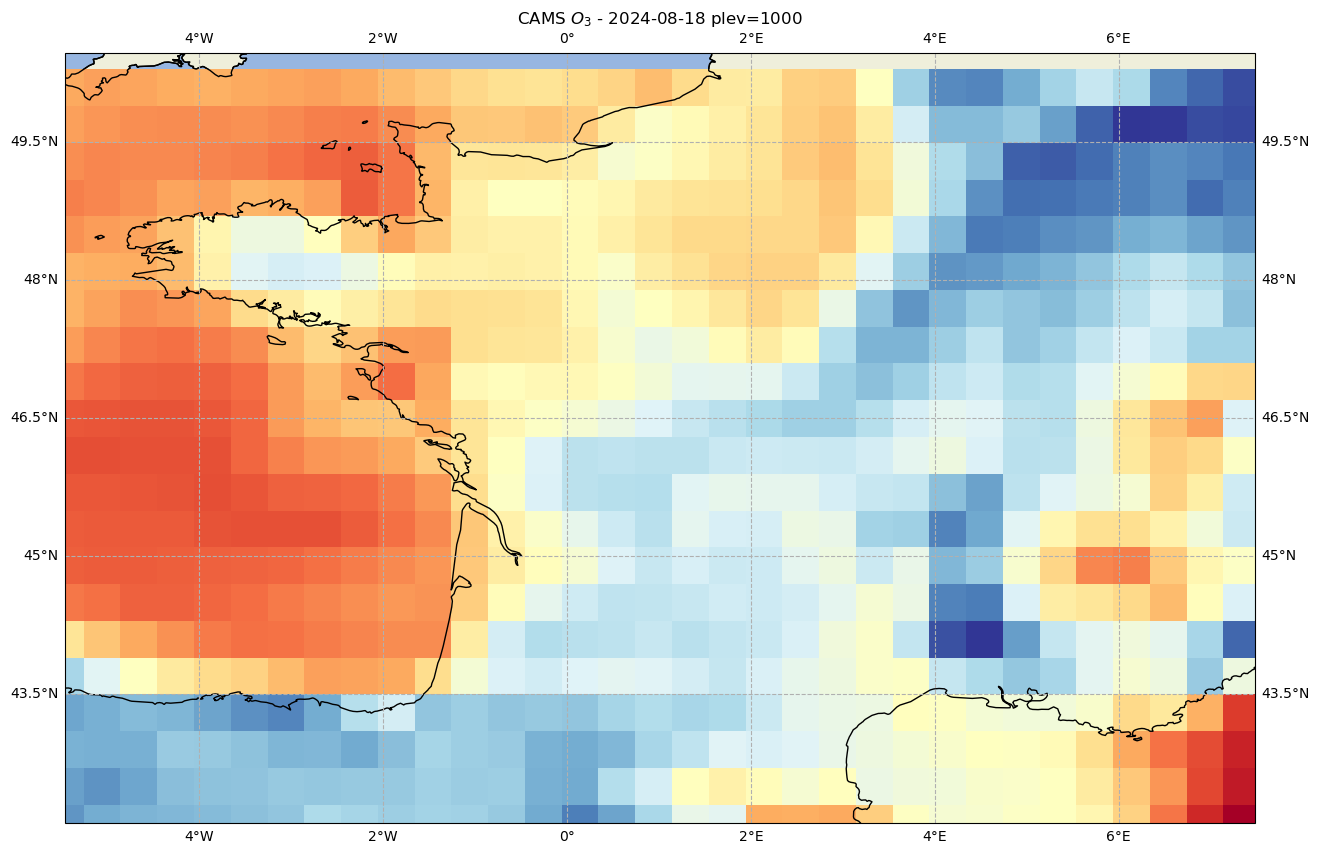

In [74]:
_, ax = create_figure()
plt.pcolormesh(cams_o3_assigned.longitude, 
               cams_o3_assigned.latitude, 
               cams_o3_assigned.sel(forecast_period='2024-08-18 03:00:00', pressure_level=1000),
               cmap='RdYlBu_r',
               shading='auto',
               transform=ccrs.PlateCarree())
plt.title('CAMS $O_3$ - 2024-08-18 plev=1000')

## References
* [Eskes, Boersma - Averaging kernels for DOAS total-column satellite retrievals](https://acp.copernicus.org/articles/3/1285/2003/acp-3-1285-2003.html)
* [Apituley et al. - Sentinel-5 precursor/TROPOMI
Level 2 Product User Manual
Ozone profiles](https://sentinels.copernicus.eu/documents/247904/2474726/Sentinel-5P-TROPOMI-Level-2-Product-User-Manual-Ozone-profiles.pdf)
* [Rodgers - Inverse methods for atmospheric sounding - Theory and practice](https://acp.copernicus.org/articles/3/1285/2003/acp-3-1285-2003.html)
* [Jacob - Introduction to Atmospheric Chemistry](https://acmg.seas.harvard.edu/education/introduction-atmospheric-chemistry)
* Wilks - Statistical Methods in Atmospheric Science, 2nd Edition